# **Pet Adoption Simple (Part II)**

This Kernel **continues my previous** "[Pet Adoption Simple](https://www.kaggle.com/ludovicoristori/pets-adoption-simple-pandas-random-forest)". Actually, when I started loading and processing the json data, that notebook became all but simple. So I took this decision: one new kernel (this) to use the data prepared and to add some modification to the basic dataframe df_all, too. 

Topics of this notebook: focus on **categorical data** and **merging different dataframes** (images, SVD of descriptions). In addition, I substituted Random Forests and XGBM with **LGBM** which I found better with columns like description or breed (categorical with many values).

Thanks to [Abishek](http://https://www.kaggle.com/abhishek/maybe-something-interesting-here) for the idea of rescaling/rounding outputs. It's the first time I have seen something like that and started using it practically anytime. Probably I abused a bit in the final part of this notebook, let's see after the submission...

# Imports and Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import os
print(os.listdir("../input"))

['pet-adoption-only-images', 'petfinder-adoption-prediction', 'pet-adoption-only-text-svd', 'pets-adoption-simple-pandas-random-forest']


In [3]:
data_path="../input/petfinder-adoption-prediction"
first_kernel_path="../input/pets-adoption-simple-pandas-random-forest"
image_kernel_path="../input/pet-adoption-only-images"
svd_kernel_path="../input/pet-adoption-only-text-svd"

In [4]:
train = pd.read_csv(data_path+"/train/train.csv")
test = pd.read_csv(data_path+"/test/test.csv")
color_labels = pd.read_csv(data_path+"/color_labels.csv")
breed_labels = pd.read_csv(data_path+"/breed_labels.csv")
state_labels = pd.read_csv(data_path+"/state_labels.csv")

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def print_columns_with_null(df):
    dfn=df.isnull().sum()
    return dfn[dfn>0]

From "Pet Adoption Simple" we have:

* df_all0, basic dataframe
* df_svd, SVD of descriptions in df_all0 and img_data 
* txt_data, data from sentiment analysis
* img_data, data from images

The preparation basically consists of merging the information in one dataframe, the "new" df_all


In [7]:
df_all0 = pd.read_csv(first_kernel_path+"/df_all0.csv")
df_all0.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,SimpleName,DescriptionLength,DescrLengthCat,SimpleRescuerID,SimpleBreed2,SimpleBreed1
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,Other Names,359,750,Other Rescuers,0,299
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,Other Names,118,250,Other Rescuers,0,265
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,Other Names,393,750,fa90fa5b1ee11c86938398b60abc32cb,0,307
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,Other Names,146,250,Other Rescuers,0,307
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,Other Names,390,750,95481e953f8aed9ec3d16fc4509537e8,0,307


In [8]:
txt_data = pd.read_csv(first_kernel_path+"/txt_data.csv")
txt_data.columns = ['PetID','sent_magnitude','sent_score','sent_language']
txt_data.head()

,PetID,sent_magnitude,sent_score,sent_language
0,b3b6d78f5,1.2,-0.1,en
1,4b31d7b1e,0.9,0.9,en
2,20bad295b,1.3,0.6,en
3,d81afce4f,0.7,0.1,en
4,dc8359e75,1.7,0.2,en


In [9]:
img_df1a = pd.read_csv(image_kernel_path+"/img_df1a_local.csv")
img_df1a.columns = ['PetID','ImageID','img_met_score','img_met_description']
img_df1a.head()

,PetID,ImageID,img_met_score,img_met_description
0,d0956e39e,7,0.990992,dog
1,d0956e39e,7,0.969505,dog like mammal
2,d0956e39e,7,0.941309,dog breed
3,d0956e39e,7,0.923620,mammal
4,d0956e39e,7,0.836046,puppy


In [10]:
img_df1c = pd.read_csv(image_kernel_path+"/img_df1c_local.csv")
img_df1c.columns = ['PetID','ImageID','img_crp_x','img_crp_y','img_crp_conf','img_crp_if']
img_df1c.head()

,PetID,ImageID,img_crp_x,img_crp_y,img_crp_conf,img_crp_if
0,d0956e39e,7,129,75,0.8,1.00
1,2275c7ba3,1,399,299,0.8,1.00
2,251f4dd60,1,359,479,0.8,1.00
3,0e6f26f19,2,278,399,0.8,0.95
4,f3abe5d8c,3,215,287,0.8,1.00


In [11]:
img_df1p = pd.read_csv(image_kernel_path+"/img_df1p_local.csv")
img_df1p.columns = ['PetID','ImageID','img_par_red','img_par_green','img_par_blue','img_par_score','img_par_pf']
img_df1p.head()

,PetID,ImageID,img_par_red,img_par_green,img_par_blue,img_par_score,img_par_pf
0,d0956e39e,7,25,25,25,0.227257,0.065105
1,d0956e39e,7,142,155,154,0.037983,0.180386
2,d0956e39e,7,48,49,46,0.159047,0.127307
3,d0956e39e,7,47,50,30,0.142071,0.030272
4,d0956e39e,7,82,85,63,0.091473,0.032138


In [12]:
des_svd_df = pd.read_csv(svd_kernel_path+"/des_svd_df.csv")
des_svd_df.iloc[:,0:10].head()

,PetID,Description,AdoptionSpeed,des_svd0,des_svd1,des_svd2,des_svd3,des_svd4,des_svd5,des_svd6
0,86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,2,0.176157,-0.058593,-0.055123,-0.013193,-0.020942,0.010318,0.033072
1,6296e909a,I just found it alone yesterday near my apartm...,0,0.128097,-0.049430,0.015260,0.024499,-0.093690,0.001221,0.012304
2,3422e4906,Their pregnant mother was dumped by her irresp...,3,0.157601,-0.049278,0.160950,-0.066263,0.036256,-0.135540,-0.031962
3,5842f1ff5,"Good guard dog, very alert, active, obedience ...",2,0.137033,-0.035897,0.062354,0.157901,0.093029,-0.031316,-0.062379
4,850a43f90,This handsome yet cute boy is up for adoption....,2,0.236096,0.011709,0.036112,-0.012568,0.029042,0.098451,0.115440


In [13]:
prev_subm = pd.read_csv("../input/pets-adoption-simple-pandas-random-forest/submission.csv")
prev_subm.head()

,PetID,AdoptionSpeed
0,378fcc4fc,2
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,3
4,43fbba852,4


# Merging dataframes

In [14]:
df_all0.shape

(18941, 30)

In [15]:
txt_data.shape

(18257, 4)

In [16]:
img_df1a.shape

(546164, 4)

In [17]:
img_df1c.shape

(58297, 6)

In [18]:
img_df1p.shape

(579150, 7)

In [19]:
des_svd_df.shape

(18941, 243)

In [20]:
dfm=df_all0
numeric_cols=['Age','PhotoAmt','Quantity','Fee','DescriptionLength']
categorical_cols=['Sterilized','FurLength','Breed1','State','AdoptionSpeed','Breed2','MaturitySize','Gender','Dewormed','Color1','Color2','Color3','Health']
cols=['PetID']+numeric_cols+categorical_cols
dfm=df_all0[cols]
dfm.shape

(18941, 19)

In [21]:
dfm=dfm.merge(txt_data,on='PetID', how='left')
categorical_cols=categorical_cols+['sent_language']
dfm.shape

(18941, 22)

In [22]:
svd=des_svd_df
svd.drop('Description',axis=1,inplace=True)
svd.drop('AdoptionSpeed',axis=1,inplace=True)
dfm=dfm.merge(svd,on='PetID', how='left')
dfm.shape

(18941, 262)

In [23]:
img_df1ar=img_df1a[img_df1a['ImageID']==1]
img_df1cr=img_df1c[img_df1c['ImageID']==1]
img_df1pr=img_df1p[img_df1p['ImageID']==1]

In [24]:
img_df1ar

,PetID,ImageID,img_met_score,img_met_description
8,2275c7ba3,1,0.994051,cat
9,2275c7ba3,1,0.925062,small to medium sized cats
10,2275c7ba3,1,0.917871,fauna
11,2275c7ba3,1,0.912494,cat like mammal
12,2275c7ba3,1,0.858864,whiskers
13,2275c7ba3,1,0.804997,domestic short haired cat
14,2275c7ba3,1,0.804121,european shorthair
15,2275c7ba3,1,0.796967,tail
16,2275c7ba3,1,0.762894,kitten
17,2275c7ba3,1,0.716186,aegean cat


In [25]:
img_df1ar1=img_df1ar.groupby(by=['PetID','ImageID'],as_index=False).agg({'img_met_score': 'max', 'img_met_description': 'first'})
img_df1ar1.drop('ImageID',axis=1,inplace=True)
img_df1ar1.columns=['PetID','img_met_score_max','img_met_des_top']
img_df1ar1.head()

,PetID,img_met_score_max,img_met_des_top
0,0008c5398,0.994370,cat
1,000a290e4,0.964141,dog
2,000fb9572,0.972133,dog
3,0011d7c25,0.992318,cat
4,00156db4a,0.956051,dog


The field img_met_des_top is almost useless ... but for the moment let's keep it as is.

The second table has not multiple rows per image

In [26]:
img_df1cr.groupby('PetID')['PetID'].count().describe()

count    14650.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: PetID, dtype: float64

In [27]:
img_df1cr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14650 entries, 1 to 58296
Data columns (total 6 columns):
PetID           14650 non-null object
ImageID         14650 non-null int64
img_crp_x       14650 non-null int64
img_crp_y       14650 non-null int64
img_crp_conf    14650 non-null float64
img_crp_if      14650 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 801.2+ KB


In [28]:
img_df1cr1=img_df1cr
img_df1cr1.drop('ImageID',axis=1,inplace=True)
img_df1cr1.head()

,PetID,img_crp_x,img_crp_y,img_crp_conf,img_crp_if
1,2275c7ba3,399,299,0.8,1.0
2,251f4dd60,359,479,0.8,1.0
9,9f41a024f,399,299,0.8,1.0
10,2eaab0cb1,269,478,0.8,1.0
11,9926c6e5b,299,399,0.8,1.0


Therefore it's enough merging it directly with the destination table. The next, please ...

In [29]:
img_df1pr.head()

,PetID,ImageID,img_par_red,img_par_green,img_par_blue,img_par_score,img_par_pf
10,2275c7ba3,1,176,77,50,0.391149,0.237513
11,2275c7ba3,1,76,84,70,0.119486,0.039109
12,2275c7ba3,1,65,60,42,0.089363,0.027142
13,2275c7ba3,1,186,197,190,0.032295,0.162071
14,2275c7ba3,1,80,79,61,0.060954,0.029917


Here we select the rows where score=max, so this is the command:

In [30]:
img_df1pr1=img_df1pr.groupby(by=['PetID','ImageID'],as_index=False).agg({'img_par_score': 'max', 
    'img_par_red': 'first','img_par_green': 'first','img_par_blue': 'first','img_par_pf':'first'})
img_df1pr1.drop('ImageID',axis=1,inplace=True)
img_df1pr1.columns = ['PetID','img_par_score_max','img_par_red_top','img_par_green_top','img_par_blue_top','img_par_pf_top']
img_df1pr1.head()

,PetID,img_par_score_max,img_par_red_top,img_par_green_top,img_par_blue_top,img_par_pf_top
0,0008c5398,0.156626,203,196,192,0.140030
1,000a290e4,0.138713,155,112,91,0.015744
2,000fb9572,0.176119,23,19,16,0.243393
3,0011d7c25,0.228336,157,147,125,0.267256
4,00156db4a,0.243056,175,155,126,0.189856


In [31]:
img_df1pr1[img_df1pr1['PetID']=='2275c7ba3']

,PetID,img_par_score_max,img_par_red_top,img_par_green_top,img_par_blue_top,img_par_pf_top
1999,2275c7ba3,0.391149,176,77,50,0.237513


Ok, it's time to merge all the images tables:

In [32]:
img=img_df1ar1
img=img.merge(img_df1cr1,on=['PetID'], how='left')
img=img.merge(img_df1pr1,on=['PetID'], how='left')
img.shape

(14650, 12)

In [33]:
img.head()

,PetID,img_met_score_max,img_met_des_top,img_crp_x,img_crp_y,img_crp_conf,img_crp_if,img_par_score_max,img_par_red_top,img_par_green_top,img_par_blue_top,img_par_pf_top
0,0008c5398,0.994370,cat,348.0,478.0,0.8,1.0,0.156626,203.0,196.0,192.0,0.140030
1,000a290e4,0.964141,dog,359.0,479.0,0.8,1.0,0.138713,155.0,112.0,91.0,0.015744
2,000fb9572,0.972133,dog,399.0,267.0,0.8,1.0,0.176119,23.0,19.0,16.0,0.243393
3,0011d7c25,0.992318,cat,298.0,399.0,0.8,1.0,0.228336,157.0,147.0,125.0,0.267256
4,00156db4a,0.956051,dog,399.0,266.0,0.8,1.0,0.243056,175.0,155.0,126.0,0.189856


In [34]:
dfm=dfm.merge(img,on='PetID', how='left')
dfm.shape

(18941, 273)

In [35]:
df_all=dfm
df_all.head()

,PetID,Age,PhotoAmt,Quantity,Fee,DescriptionLength,Sterilized,FurLength,Breed1,State,AdoptionSpeed,Breed2,MaturitySize,Gender,Dewormed,Color1,Color2,Color3,Health,sent_magnitude,sent_score,sent_language,des_svd0,des_svd1,des_svd2,des_svd3,des_svd4,des_svd5,des_svd6,des_svd7,des_svd8,des_svd9,des_svd10,des_svd11,des_svd12,des_svd13,des_svd14,des_svd15,des_svd16,des_svd17,...,des_svd211,des_svd212,des_svd213,des_svd214,des_svd215,des_svd216,des_svd217,des_svd218,des_svd219,des_svd220,des_svd221,des_svd222,des_svd223,des_svd224,des_svd225,des_svd226,des_svd227,des_svd228,des_svd229,des_svd230,des_svd231,des_svd232,des_svd233,des_svd234,des_svd235,des_svd236,des_svd237,des_svd238,des_svd239,img_met_score_max,img_met_des_top,img_crp_x,img_crp_y,img_crp_conf,img_crp_if,img_par_score_max,img_par_red_top,img_par_green_top,img_par_blue_top,img_par_pf_top
0,86e1089a3,3,1.0,1,100,359,2,1,299,41326,2,0,1,1,2,1,7,0,1,2.4,0.3,en,0.176157,-0.058593,-0.055123,-0.013193,-0.020942,0.010318,0.033072,-0.017084,-0.054543,0.014061,-0.017831,-0.043603,-0.015223,0.000065,-0.005528,0.021210,-0.033693,0.025626,...,-0.036052,0.031942,0.030851,0.009904,-0.012054,0.044810,-0.048370,0.077345,0.057086,0.013706,-0.009576,0.006897,0.024264,0.018091,-0.042431,-0.027433,0.024162,0.025513,-0.076954,-0.006905,-0.031750,-0.019059,-0.035282,-0.044963,-0.057509,-0.038373,0.029052,-0.000595,-0.004377,0.990786,cat,359.0,479.0,0.8,1.00,0.302789,25.0,20.0,21.0,0.393910
1,6296e909a,1,2.0,1,0,118,3,2,265,41401,0,0,2,1,3,1,2,0,1,0.7,-0.2,en,0.128097,-0.049430,0.015260,0.024499,-0.093690,0.001221,0.012304,-0.001562,0.044264,-0.008578,-0.030576,0.006697,-0.016197,0.032324,-0.024281,0.037137,-0.025602,0.000298,...,0.020670,0.017817,-0.052306,0.064538,-0.025580,-0.023718,0.001434,0.022659,-0.010838,0.036265,0.013152,0.015638,0.049603,-0.048900,0.022094,0.043165,0.005498,0.016301,0.039934,0.050731,-0.010858,0.015532,-0.001942,0.006700,-0.067678,-0.008579,-0.015659,-0.009815,0.024507,0.981269,cat,398.0,376.0,0.8,1.00,0.348178,19.0,24.0,17.0,0.261856
2,3422e4906,1,7.0,1,0,393,2,2,307,41326,3,0,2,1,1,2,7,0,1,3.7,0.2,en,0.157601,-0.049278,0.160950,-0.066263,0.036256,-0.135540,-0.031962,-0.064737,-0.008405,-0.028567,-0.024777,0.094728,-0.162234,-0.116869,-0.168925,-0.101749,0.129609,-0.035091,...,0.011933,-0.011994,-0.001557,-0.020377,-0.010703,0.027974,-0.035138,0.022083,0.111477,-0.013193,0.011497,-0.029244,-0.021700,0.029608,-0.004886,-0.001987,-0.009753,-0.004799,0.024737,-0.025735,-0.044488,0.015629,-0.005847,0.018048,0.017673,0.035517,0.003264,-0.041889,0.007283,0.960457,dog,299.0,399.0,0.8,1.00,0.333318,61.0,55.0,51.0,0.055064
3,5842f1ff5,4,8.0,1,150,146,2,1,307,41401,2,0,2,2,1,1,2,0,1,0.9,0.9,en,0.137033,-0.035897,0.062354,0.157901,0.093029,-0.031316,-0.062379,0.012264,-0.008870,-0.058089,-0.054322,0.104882,-0.002355,-0.008330,0.106512,-0.050533,-0.059803,-0.099626,...,-0.002189,0.017762,-0.001187,0.012129,0.009573,-0.006237,0.020703,0.020352,-0.007061,0.006053,0.029703,0.011097,0.010360,-0.034590,0.014874,-0.050894,-0.035955,0.004486,0.000270,-0.023083,0.021792,0.009947,-0.004626,0.003230,-0.014265,0.001156,0.017410,0.008715,-0.004372,0.978698,dog,399.0,299.0,0.8,1.00,0.136823,54.0,50.0,47.0,0.127818
4,850a43f90,1,3.0,1,0,390,2,1,307,41326,2,0,2,1,2,1,0,0,1,3.7,0.6,en,0.236096,0.011709,0.036112,-0.012568,0.029042,0.098451,0.115440,0.073644,0.150445,0.007917,-0.022981,-0.105952,-0.048570,-0.016434,-0.021780,-0.046825,0.073285,-0.030872,...,-0.045358,-0.026161,-0.018433,-0.014062,-0.031894,-0.072421,0.041616,0.015202,0.020706,-0.001691,-0.038354,-0.003179,0.015902,-0.002748,-0.001002,-0.023827,0.008764,-0.006669,-0.010600,0.005329,-0.000468,-0.028185,0.017521,0.013774,-0.042406,-0.000303,-0.033501,0.030531,-0.024337,0.984346,dog,517.0,426.0,0.8,0.98,0.256168,24.0,19.0,21.0,0.126334


In [36]:
print_columns_with_null(df_all)

sent_magnitude        684
sent_score            684
sent_language         684
img_met_score_max    4291
img_met_des_top      4291
img_crp_x            4293
img_crp_y            4293
img_crp_conf         4293
img_crp_if           4293
img_par_score_max    4350
img_par_red_top      4350
img_par_green_top    4350
img_par_blue_top     4350
img_par_pf_top       4350
dtype: int64

In [37]:
df_all['sent_magnitude'].fillna(0, inplace=True) # 0=no comments received
df_all['sent_score'].fillna(0, inplace=True) # 0=no comments received
df_all['sent_language'].fillna('en', inplace=True) # default=english

In [38]:
df_all['img_met_score_max'].fillna(-1, inplace=True) 
df_all['img_met_des_top'].fillna("None", inplace=True) 

In [39]:
df_all['img_crp_x'].fillna(-1, inplace=True) 
df_all['img_crp_y'].fillna(-1, inplace=True)
df_all['img_crp_conf'].fillna(0, inplace=True) 
df_all['img_crp_if'].fillna(0, inplace=True)

In [40]:
df_all['img_par_score_max'].fillna(0, inplace=True) 
df_all['img_par_red_top'].fillna(-1, inplace=True)
df_all['img_par_green_top'].fillna(-1, inplace=True)
df_all['img_par_blue_top'].fillna(-1, inplace=True)
df_all['img_par_pf_top'].fillna(0, inplace=True) 

In [41]:
print_columns_with_null(df_all)

Series([], dtype: int64)

In [42]:
categorical_cols=categorical_cols+['img_met_des_top']
categorical_cols

['Sterilized',
 'FurLength',
 'Breed1',
 'State',
 'AdoptionSpeed',
 'Breed2',
 'MaturitySize',
 'Gender',
 'Dewormed',
 'Color1',
 'Color2',
 'Color3',
 'Health',
 'sent_language',
 'img_met_des_top']

In [43]:
df_all[categorical_cols]=df_all[categorical_cols].apply(lambda c : c.astype('category'))

# Modelling

In [44]:
df_all.to_csv('df_all.csv')
df_all.head()

,PetID,Age,PhotoAmt,Quantity,Fee,DescriptionLength,Sterilized,FurLength,Breed1,State,AdoptionSpeed,Breed2,MaturitySize,Gender,Dewormed,Color1,Color2,Color3,Health,sent_magnitude,sent_score,sent_language,des_svd0,des_svd1,des_svd2,des_svd3,des_svd4,des_svd5,des_svd6,des_svd7,des_svd8,des_svd9,des_svd10,des_svd11,des_svd12,des_svd13,des_svd14,des_svd15,des_svd16,des_svd17,...,des_svd211,des_svd212,des_svd213,des_svd214,des_svd215,des_svd216,des_svd217,des_svd218,des_svd219,des_svd220,des_svd221,des_svd222,des_svd223,des_svd224,des_svd225,des_svd226,des_svd227,des_svd228,des_svd229,des_svd230,des_svd231,des_svd232,des_svd233,des_svd234,des_svd235,des_svd236,des_svd237,des_svd238,des_svd239,img_met_score_max,img_met_des_top,img_crp_x,img_crp_y,img_crp_conf,img_crp_if,img_par_score_max,img_par_red_top,img_par_green_top,img_par_blue_top,img_par_pf_top
0,86e1089a3,3,1.0,1,100,359,2,1,299,41326,2,0,1,1,2,1,7,0,1,2.4,0.3,en,0.176157,-0.058593,-0.055123,-0.013193,-0.020942,0.010318,0.033072,-0.017084,-0.054543,0.014061,-0.017831,-0.043603,-0.015223,0.000065,-0.005528,0.021210,-0.033693,0.025626,...,-0.036052,0.031942,0.030851,0.009904,-0.012054,0.044810,-0.048370,0.077345,0.057086,0.013706,-0.009576,0.006897,0.024264,0.018091,-0.042431,-0.027433,0.024162,0.025513,-0.076954,-0.006905,-0.031750,-0.019059,-0.035282,-0.044963,-0.057509,-0.038373,0.029052,-0.000595,-0.004377,0.990786,cat,359.0,479.0,0.8,1.00,0.302789,25.0,20.0,21.0,0.393910
1,6296e909a,1,2.0,1,0,118,3,2,265,41401,0,0,2,1,3,1,2,0,1,0.7,-0.2,en,0.128097,-0.049430,0.015260,0.024499,-0.093690,0.001221,0.012304,-0.001562,0.044264,-0.008578,-0.030576,0.006697,-0.016197,0.032324,-0.024281,0.037137,-0.025602,0.000298,...,0.020670,0.017817,-0.052306,0.064538,-0.025580,-0.023718,0.001434,0.022659,-0.010838,0.036265,0.013152,0.015638,0.049603,-0.048900,0.022094,0.043165,0.005498,0.016301,0.039934,0.050731,-0.010858,0.015532,-0.001942,0.006700,-0.067678,-0.008579,-0.015659,-0.009815,0.024507,0.981269,cat,398.0,376.0,0.8,1.00,0.348178,19.0,24.0,17.0,0.261856
2,3422e4906,1,7.0,1,0,393,2,2,307,41326,3,0,2,1,1,2,7,0,1,3.7,0.2,en,0.157601,-0.049278,0.160950,-0.066263,0.036256,-0.135540,-0.031962,-0.064737,-0.008405,-0.028567,-0.024777,0.094728,-0.162234,-0.116869,-0.168925,-0.101749,0.129609,-0.035091,...,0.011933,-0.011994,-0.001557,-0.020377,-0.010703,0.027974,-0.035138,0.022083,0.111477,-0.013193,0.011497,-0.029244,-0.021700,0.029608,-0.004886,-0.001987,-0.009753,-0.004799,0.024737,-0.025735,-0.044488,0.015629,-0.005847,0.018048,0.017673,0.035517,0.003264,-0.041889,0.007283,0.960457,dog,299.0,399.0,0.8,1.00,0.333318,61.0,55.0,51.0,0.055064
3,5842f1ff5,4,8.0,1,150,146,2,1,307,41401,2,0,2,2,1,1,2,0,1,0.9,0.9,en,0.137033,-0.035897,0.062354,0.157901,0.093029,-0.031316,-0.062379,0.012264,-0.008870,-0.058089,-0.054322,0.104882,-0.002355,-0.008330,0.106512,-0.050533,-0.059803,-0.099626,...,-0.002189,0.017762,-0.001187,0.012129,0.009573,-0.006237,0.020703,0.020352,-0.007061,0.006053,0.029703,0.011097,0.010360,-0.034590,0.014874,-0.050894,-0.035955,0.004486,0.000270,-0.023083,0.021792,0.009947,-0.004626,0.003230,-0.014265,0.001156,0.017410,0.008715,-0.004372,0.978698,dog,399.0,299.0,0.8,1.00,0.136823,54.0,50.0,47.0,0.127818
4,850a43f90,1,3.0,1,0,390,2,1,307,41326,2,0,2,1,2,1,0,0,1,3.7,0.6,en,0.236096,0.011709,0.036112,-0.012568,0.029042,0.098451,0.115440,0.073644,0.150445,0.007917,-0.022981,-0.105952,-0.048570,-0.016434,-0.021780,-0.046825,0.073285,-0.030872,...,-0.045358,-0.026161,-0.018433,-0.014062,-0.031894,-0.072421,0.041616,0.015202,0.020706,-0.001691,-0.038354,-0.003179,0.015902,-0.002748,-0.001002,-0.023827,0.008764,-0.006669,-0.010600,0.005329,-0.000468,-0.028185,0.017521,0.013774,-0.042406,-0.000303,-0.033501,0.030531,-0.024337,0.984346,dog,517.0,426.0,0.8,0.98,0.256168,24.0,19.0,21.0,0.126334


In [45]:
df_all.dtypes[df_all.dtypes=='object']

PetID    object
dtype: object

In [46]:
df_all.columns

Index(['PetID', 'Age', 'PhotoAmt', 'Quantity', 'Fee', 'DescriptionLength',
       'Sterilized', 'FurLength', 'Breed1', 'State',
       ...
       'img_met_des_top', 'img_crp_x', 'img_crp_y', 'img_crp_conf',
       'img_crp_if', 'img_par_score_max', 'img_par_red_top',
       'img_par_green_top', 'img_par_blue_top', 'img_par_pf_top'],
      dtype='object', length=273)

In [47]:
dftrain=df_all[np.invert(df_all['AdoptionSpeed']==-1)].copy()
dftest=df_all[df_all['AdoptionSpeed']==-1].copy()

In [48]:
dftest_ids=dftest['PetID']
dftest_ids.head()

14993    378fcc4fc
14994    73c10e136
14995    72000c4c5
14996    e147a4b9f
14997    43fbba852
Name: PetID, dtype: object

In [49]:
dftrain=dftrain.drop(['PetID'],axis=1)
dftest=dftest.drop(['PetID'],axis=1)

In [50]:
dftest=dftest.drop('AdoptionSpeed',axis=1)
y = dftrain['AdoptionSpeed']
X = dftrain.drop('AdoptionSpeed',axis=1)

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=123)

In [52]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

Classifier Choice: I used **LGBM instead of XGBM** to avoid the "dummification" of columns like description or breed. With this classificator you can deal with such variables simply using the conversion by astype('category'). **We have to perform a Classification but we use the LGBM Regressor followed by a custom rounding** (credits: Abishek).

In [53]:
import lightgbm as lgb

In [54]:
cat_features=[x for x in categorical_cols if x!='AdoptionSpeed']

In [55]:
parameters = {'application': 'regression',
              'boosting': 'gbdt',
              'metric': 'rmse',
              'max_bin' : 8,
              'num_leaves': 12,
              'max_depth': 4,
              'learning_rate': 0.01,
              'bagging_fraction': 0.8,
              'feature_fraction': 0.8,
              'min_split_gain': 0.01,
              'min_child_samples': 128,
              'min_child_weight': 0.1,
              'data_random_seed': 123,
              'verbosity': -1,
              'early_stopping_rounds': 10,
              'num_rounds': 1000}
evals_result={}

In [56]:
def qks(a,b):
    return cohen_kappa_score(np.round(a), np.round(b), weights='quadratic')

Let's perform a **KFold validation with 5 splits using 90% of the Kaggle's train set** (X_train, y_train). In the single-step function we have X and y only beacause train_idx and test_idx are referencing the global index. In do_step_k() we use 4/5 of the data to train (lgb_train_set), the remaining part as validation. Finally we evaluate 3 outputs: the prediction based on X_train (4/5+1/5) and the one based on the 10% completly new to this lgbm.

In [57]:
def do_step_k(X,y,train_idx,test_idx,X_test,y_test) :
    X_train_k=X.iloc[train_idx]
    y_train_k=y.iloc[train_idx]
    X_test_k=X.iloc[test_idx]
    y_test_k=y.iloc[test_idx]
    lgb_train_set = lgb.Dataset(X_train_k, label=y_train_k, categorical_feature=cat_features,free_raw_data=False)
    lgb_test_set = lgb.Dataset(X_test_k, label=y_test_k,free_raw_data=False)
    lgbm=lgb.LGBMRegressor()
    lgbm = lgb.train(parameters,
                     train_set=lgb_train_set,
                     valid_sets=[lgb_train_set,lgb_test_set],
                     verbose_eval=100,
                     evals_result=evals_result)
    best_round=lgbm.best_iteration
    y_train_pred_k = lgbm.predict(X_train_k,num_iteration=best_round)
    y_test_int_pred_k1 = lgbm.predict(X_test_k,num_iteration=best_round)
    y_test_ext_pred_k1 = lgbm.predict(X_test,num_iteration=best_round)
    qks1=qks(y_train_pred_k,y_train_k)
    qks2=qks(y_test_int_pred_k1,y_test_k)
    qks3=qks(y_test_ext_pred_k1, y_test)
    y_test_ext=y_test_ext_pred_k1
    return best_round,qks1,qks2,qks3,y_test_ext

In [58]:
kf_splits=5
k_fold = KFold(n_splits=kf_splits, shuffle=True)
k=0
df_qks=pd.DataFrame(columns=['best_round','qks_train','qks_test_int','qks_test_ext'])
df_y=pd.DataFrame(index=X_test.index)
for train_idx, test_idx in k_fold.split(X_train) :
    k=k+1
    print('Step k={}'.format(k))
    print('Train: %s | test: %s' % (train_idx, test_idx))
    iteration,q1,q2,q3,y_test_prev=do_step_k(X_train,y_train,train_idx,test_idx,X_test,y_test)
    df_qks.loc[k]=[iteration,q1,q2,q3]
    df_y[k]=y_test_prev

Step k=1
Train: [    0     2     3 ... 13490 13491 13492] | test: [    1     4    12 ... 13477 13480 13482]
Training until validation scores don't improve for 10 rounds.
[100]	training's rmse: 1.09922	valid_1's rmse: 1.12544
[200]	training's rmse: 1.06804	valid_1's rmse: 1.10088
[300]	training's rmse: 1.04915	valid_1's rmse: 1.09065
[400]	training's rmse: 1.0338	valid_1's rmse: 1.08328
[500]	training's rmse: 1.0209	valid_1's rmse: 1.07809
[600]	training's rmse: 1.00892	valid_1's rmse: 1.07439
[700]	training's rmse: 0.997507	valid_1's rmse: 1.07165
[800]	training's rmse: 0.986601	valid_1's rmse: 1.0696
[900]	training's rmse: 0.976004	valid_1's rmse: 1.06747
Early stopping, best iteration is:
[913]	training's rmse: 0.974653	valid_1's rmse: 1.06715
Step k=2
Train: [    0     1     2 ... 13488 13491 13492] | test: [    6    13    19 ... 13484 13489 13490]
Training until validation scores don't improve for 10 rounds.
[100]	training's rmse: 1.10005	valid_1's rmse: 1.11185
[200]	training's rm

In [59]:
df_qks

,best_round,qks_train,qks_test_int,qks_test_ext
1,913.0,0.388181,0.291809,0.300686
2,1000.0,0.407434,0.274102,0.315300
3,1000.0,0.400739,0.306415,0.309991
4,848.0,0.382778,0.286317,0.302407
5,1000.0,0.402855,0.300862,0.291838


In [60]:
ym=(df_y.iloc[:,0]+df_y.iloc[:,1]+df_y.iloc[:,2]+df_y.iloc[:,3]+df_y.iloc[:,4])/5
ym.describe()

count    1500.000000
mean        2.517334
std         0.461495
min         1.244892
25%         2.158311
50%         2.472050
75%         2.839383
max         3.752648
dtype: float64

In [61]:
df_all[df_all['AdoptionSpeed'].astype(int)>=0]['AdoptionSpeed'].value_counts()

 4    4197
 2    4037
 3    3259
 1    3090
 0     410
-1       0
Name: AdoptionSpeed, dtype: int64

Ok, I tried with a lot of different combinations of parameters but is very difficult to have a train error less than rmse=1%. But the most important thing is that with these predictions, it's impossible to fit the original distribution of Adoption Speed. For example, we have



In [62]:
sum(ym>3.5)

21

So this is the idea I think I got from the OptimizeRounder: **why simply rounding the output of LGBM**? Why not use the **additional degree of freedom** coming from a custom rounder? 

Here is a function to apply a vector of custom limits:

In [63]:
def apply_lim(y_calc,limits):
    y_round=np.zeros(len(y_calc))
    for i,yc in enumerate(y_calc):
        if (yc<=limits[0]):
            y_round[i]=0
        if ((yc>limits[0])&(yc<=limits[1])): 
            y_round[i]=1
        if ((yc>limits[1])&(yc<=limits[2])): 
            y_round[i]=2
        if ((yc>limits[2])&(yc<=limits[3])):
            y_round[i]=3
        if (yc>limits[3]):
            y_round[i]=4
    return y_round

Now, let's perform a new train on the "whole" training set (90%):

In [64]:
lgb_train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features,free_raw_data=False)
lgb_test_set = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

In [65]:
lgbm=lgb.train(parameters,
               train_set=lgb_train_set,
               valid_sets=[lgb_train_set,lgb_test_set],
               verbose_eval=0,
               evals_result=evals_result)

In [66]:
y_test_pred = lgbm.predict(X_test)

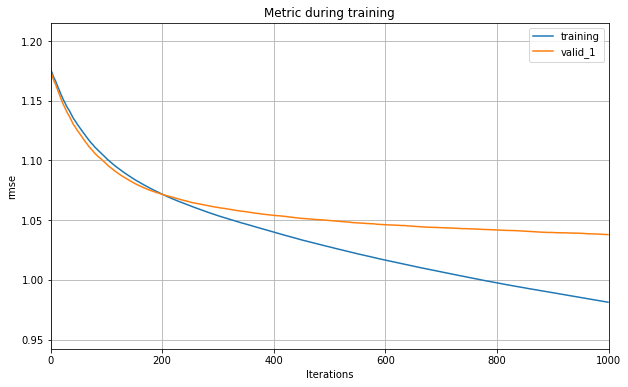

In [67]:
ax = lgb.plot_metric(evals_result, metric='rmse',figsize=(10, 6))

Ok, the same results as before. This is the distribution of our output:

(array([ 11.,  53., 159., 266., 308., 266., 184., 145.,  89.,  19.]),
 array([1.2719216 , 1.52249041, 1.77305923, 2.02362804, 2.27419685,
        2.52476566, 2.77533448, 3.02590329, 3.2764721 , 3.52704091,
        3.77760972]),
 <a list of 10 Patch objects>)

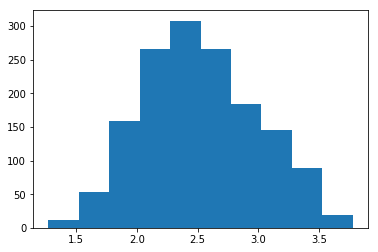

In [68]:
plt.hist(y_test_pred)

Let's try to map it into the original one:

In [69]:
opt_limits=[1.5,2.15,2.5,3]

In [70]:
y_test_pred_r = apply_lim(y_test_pred,opt_limits)

In [71]:
pd.DataFrame(confusion_matrix(y_test, y_test_pred_r))

,0,1,2,3,4
0,2,21,13,12,4
1,6,127,95,56,11
2,2,123,144,133,31
3,1,67,83,116,56
4,0,24,62,140,171


In [72]:
accuracy_score(y_test,y_test_pred_r)

0.37333333333333335

In [73]:
cohen_kappa_score(y_test_pred_r, y_test, weights='quadratic')

0.4500068495375503

We these limits we optimised the behavior with the train set.

In [74]:
opt_limits=[1.5,2.15,2.5,3]

But we can see that they don't perform as well with the real test set, as they ten to classify a lot of 3 and 4. Ok, in some ways we are rolling the dices. To have predictions with a distribution more similar to the original one this is the correction we can try to apply:

In [75]:
opt_limits=[2.15,2.8,3.12,3.35]

In [76]:
y_pred_lgb = apply_lim(lgbm.predict(dftest),opt_limits)

# Final Submission

In [77]:
y_pred = y_pred_lgb.astype('int')

In [78]:
subm=pd.DataFrame({'PetID': dftest_ids,'AdoptionSpeed': y_pred})
subm.head()

,PetID,AdoptionSpeed
14993,378fcc4fc,2
14994,73c10e136,3
14995,72000c4c5,4
14996,e147a4b9f,2
14997,43fbba852,4


In [79]:
subm['AdoptionSpeed'].value_counts()

1    1161
2    1039
4     958
3     742
0      48
Name: AdoptionSpeed, dtype: int64

In [80]:
subm.to_csv('submission.csv', index=False)

Ok, the next step is to understand why it's work, or better what it's wrong with the initial LGBM model ...

In [81]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,14993.0,10.452078,18.155790,0.000000,2.000000,3.000000,12.000000,255.000000
PhotoAmt,14993.0,3.889215,3.487810,0.000000,2.000000,3.000000,5.000000,30.000000
Quantity,14993.0,1.576069,1.472477,1.000000,1.000000,1.000000,1.000000,20.000000
Fee,14993.0,21.259988,78.414548,0.000000,0.000000,0.000000,0.000000,3000.000000
DescriptionLength,14993.0,339.320550,373.358700,1.000000,117.000000,238.000000,431.000000,6664.000000
sent_magnitude,14993.0,2.049436,2.038821,0.000000,0.800000,1.600000,2.800000,32.000000
sent_score,14993.0,0.270626,0.276728,-0.900000,0.100000,0.200000,0.400000,0.900000
des_svd0,14993.0,0.142201,0.056343,0.000000,0.105644,0.143367,0.178909,0.350637
des_svd1,14993.0,-0.006028,0.123811,-0.102948,-0.050384,-0.035689,-0.009349,0.934396
des_svd2,14993.0,0.005291,0.084759,-0.260680,-0.041670,-0.002159,0.035606,0.544845
